## Natural Image Rendering Visualization Based on Saliency


In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os
from collections import Counter
from scipy.ndimage.filters import gaussian_filter

os.environ["DEVICE"] = "cuda0" # This is necessary if you want to run the pygpu tests
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras import backend
from numba import cuda
import warnings
warnings.filterwarnings("ignore")


# Root directory of the project
ROOT_DIR = os.path.abspath("")
import sys

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
import coco
from tqdm import tqdm_notebook as tqdm
from scipy.ndimage import gaussian_filter



In [9]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config = config)
set_session(sess)

In [10]:
# Path to raw images
path = '/home/matteo/Dropbox/code-chart-data/training_data/salicon/'
jpg_path = os.path.join(path,'raw_img')

# Path to saliency predictions by the model
pred_path = '/home/matteo/_Importance/local_dataset/MD_saliency'
time_points = [500, 3000, 5000]
saliency_paths =  [os.path.join(pred_path,'{}'.format(time)) for time in time_points]



In [11]:
ori_imnames = os.listdir(jpg_path)
sal_imnames = [os.listdir(saliency_path) for saliency_path in saliency_paths]

In [12]:
get_filetype = lambda file: file.split('.')[-1]

ori_filetype = get_filetype(ori_imnames[0])
sal_filetype = get_filetype(sal_imnames[0][0])
shared_imname = set([imname.split('.')[0] for imname in ori_imnames])
for imnames in sal_imnames:
    shared_imname = shared_imname & set([imname.split('.')[0] for imname in imnames])
shared_imname = list(shared_imname)

In [13]:
# Mask RCNN Setup Code 

# Download MaskRCNN (https://github.com/matterport/Mask_RCNN) and put mask_rcnn_coco.h5 in the applications folder of this project.
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()    
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [14]:
# COCO Class names for Mask RCNN
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [15]:
images_list = sorted(shared_imname)
time_folders = ["simp_{}".format(t) for t in time_points]

In [18]:
selected_images= ["COCO_train2014_000000065329", "COCO_train2014_000000110404",
"COCO_train2014_000000005638", "COCO_train2014_000000018780", "COCO_train2014_000000182967",
       "COCO_train2014_000000265625", "COCO_train2014_000000117722"]

PLOT = True
SAVE_SUBSET = True
RESIZE = True
dim = (640,480)
save_dict = {'image':{}, 'r':{}, 'combined_mask': {}, 'counts': {}}
save_dict_time = [{'img_patches':{}, 'heatmap':{}} for time in time_points]


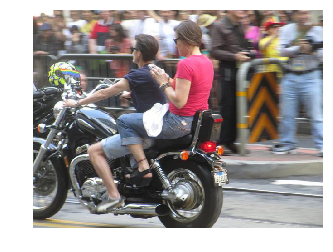

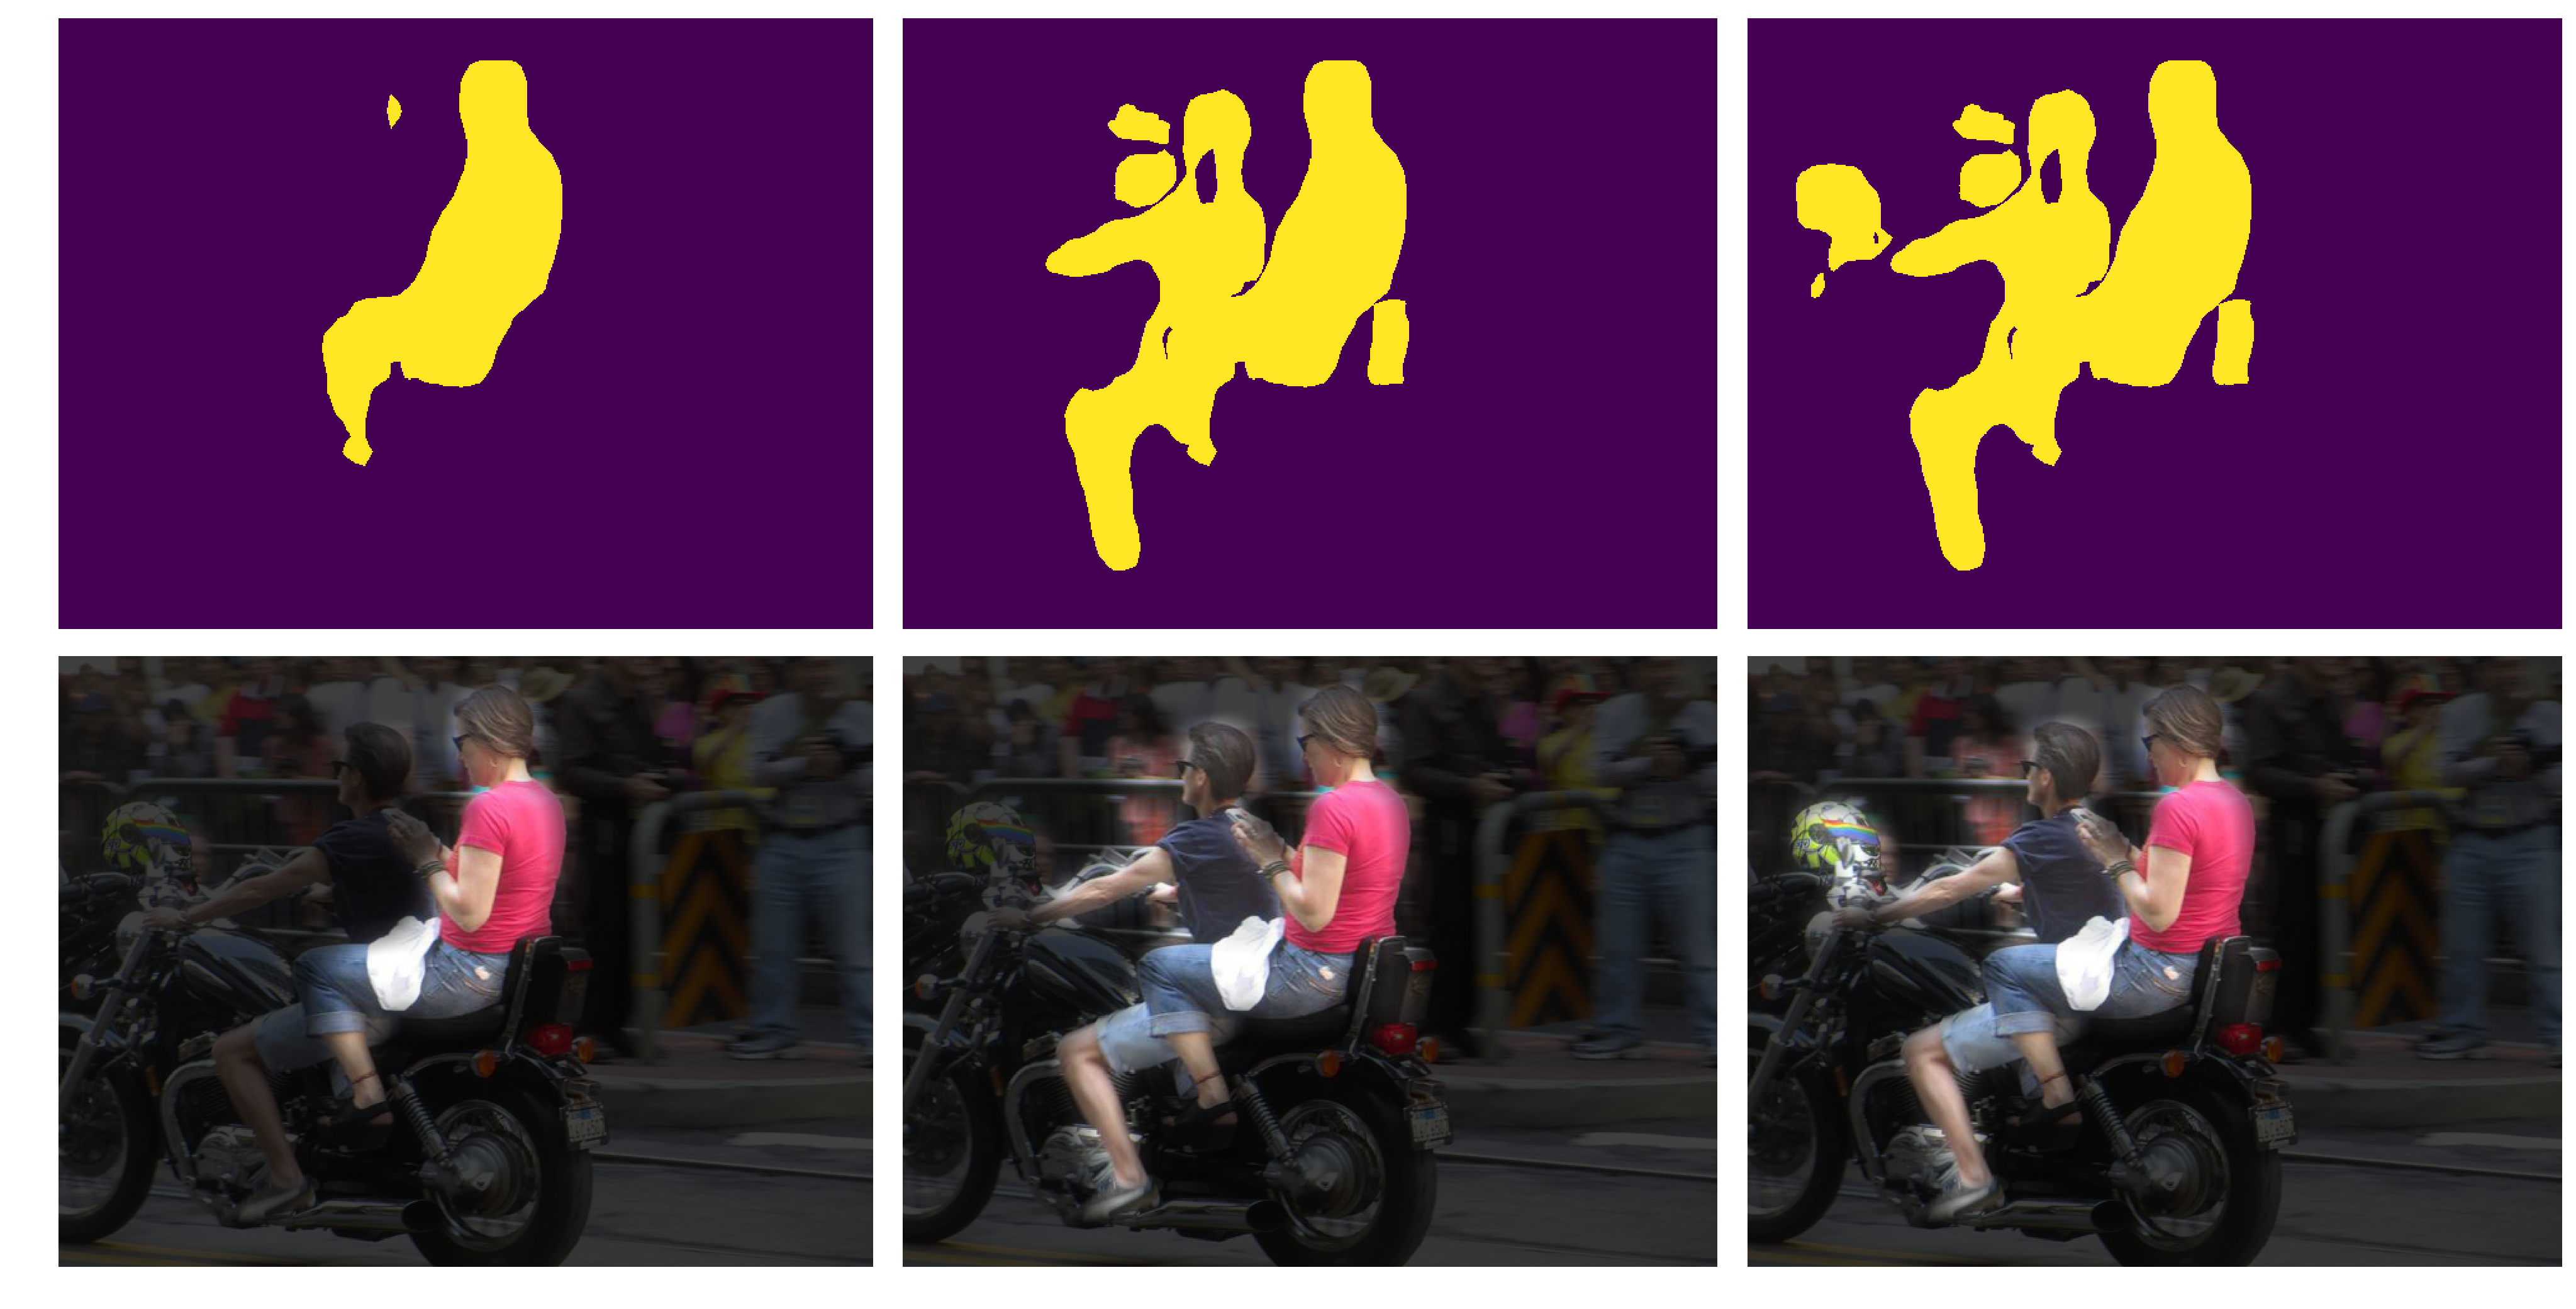

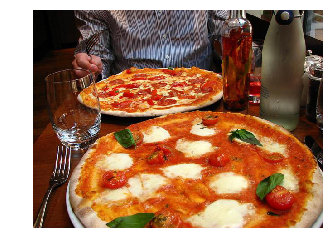

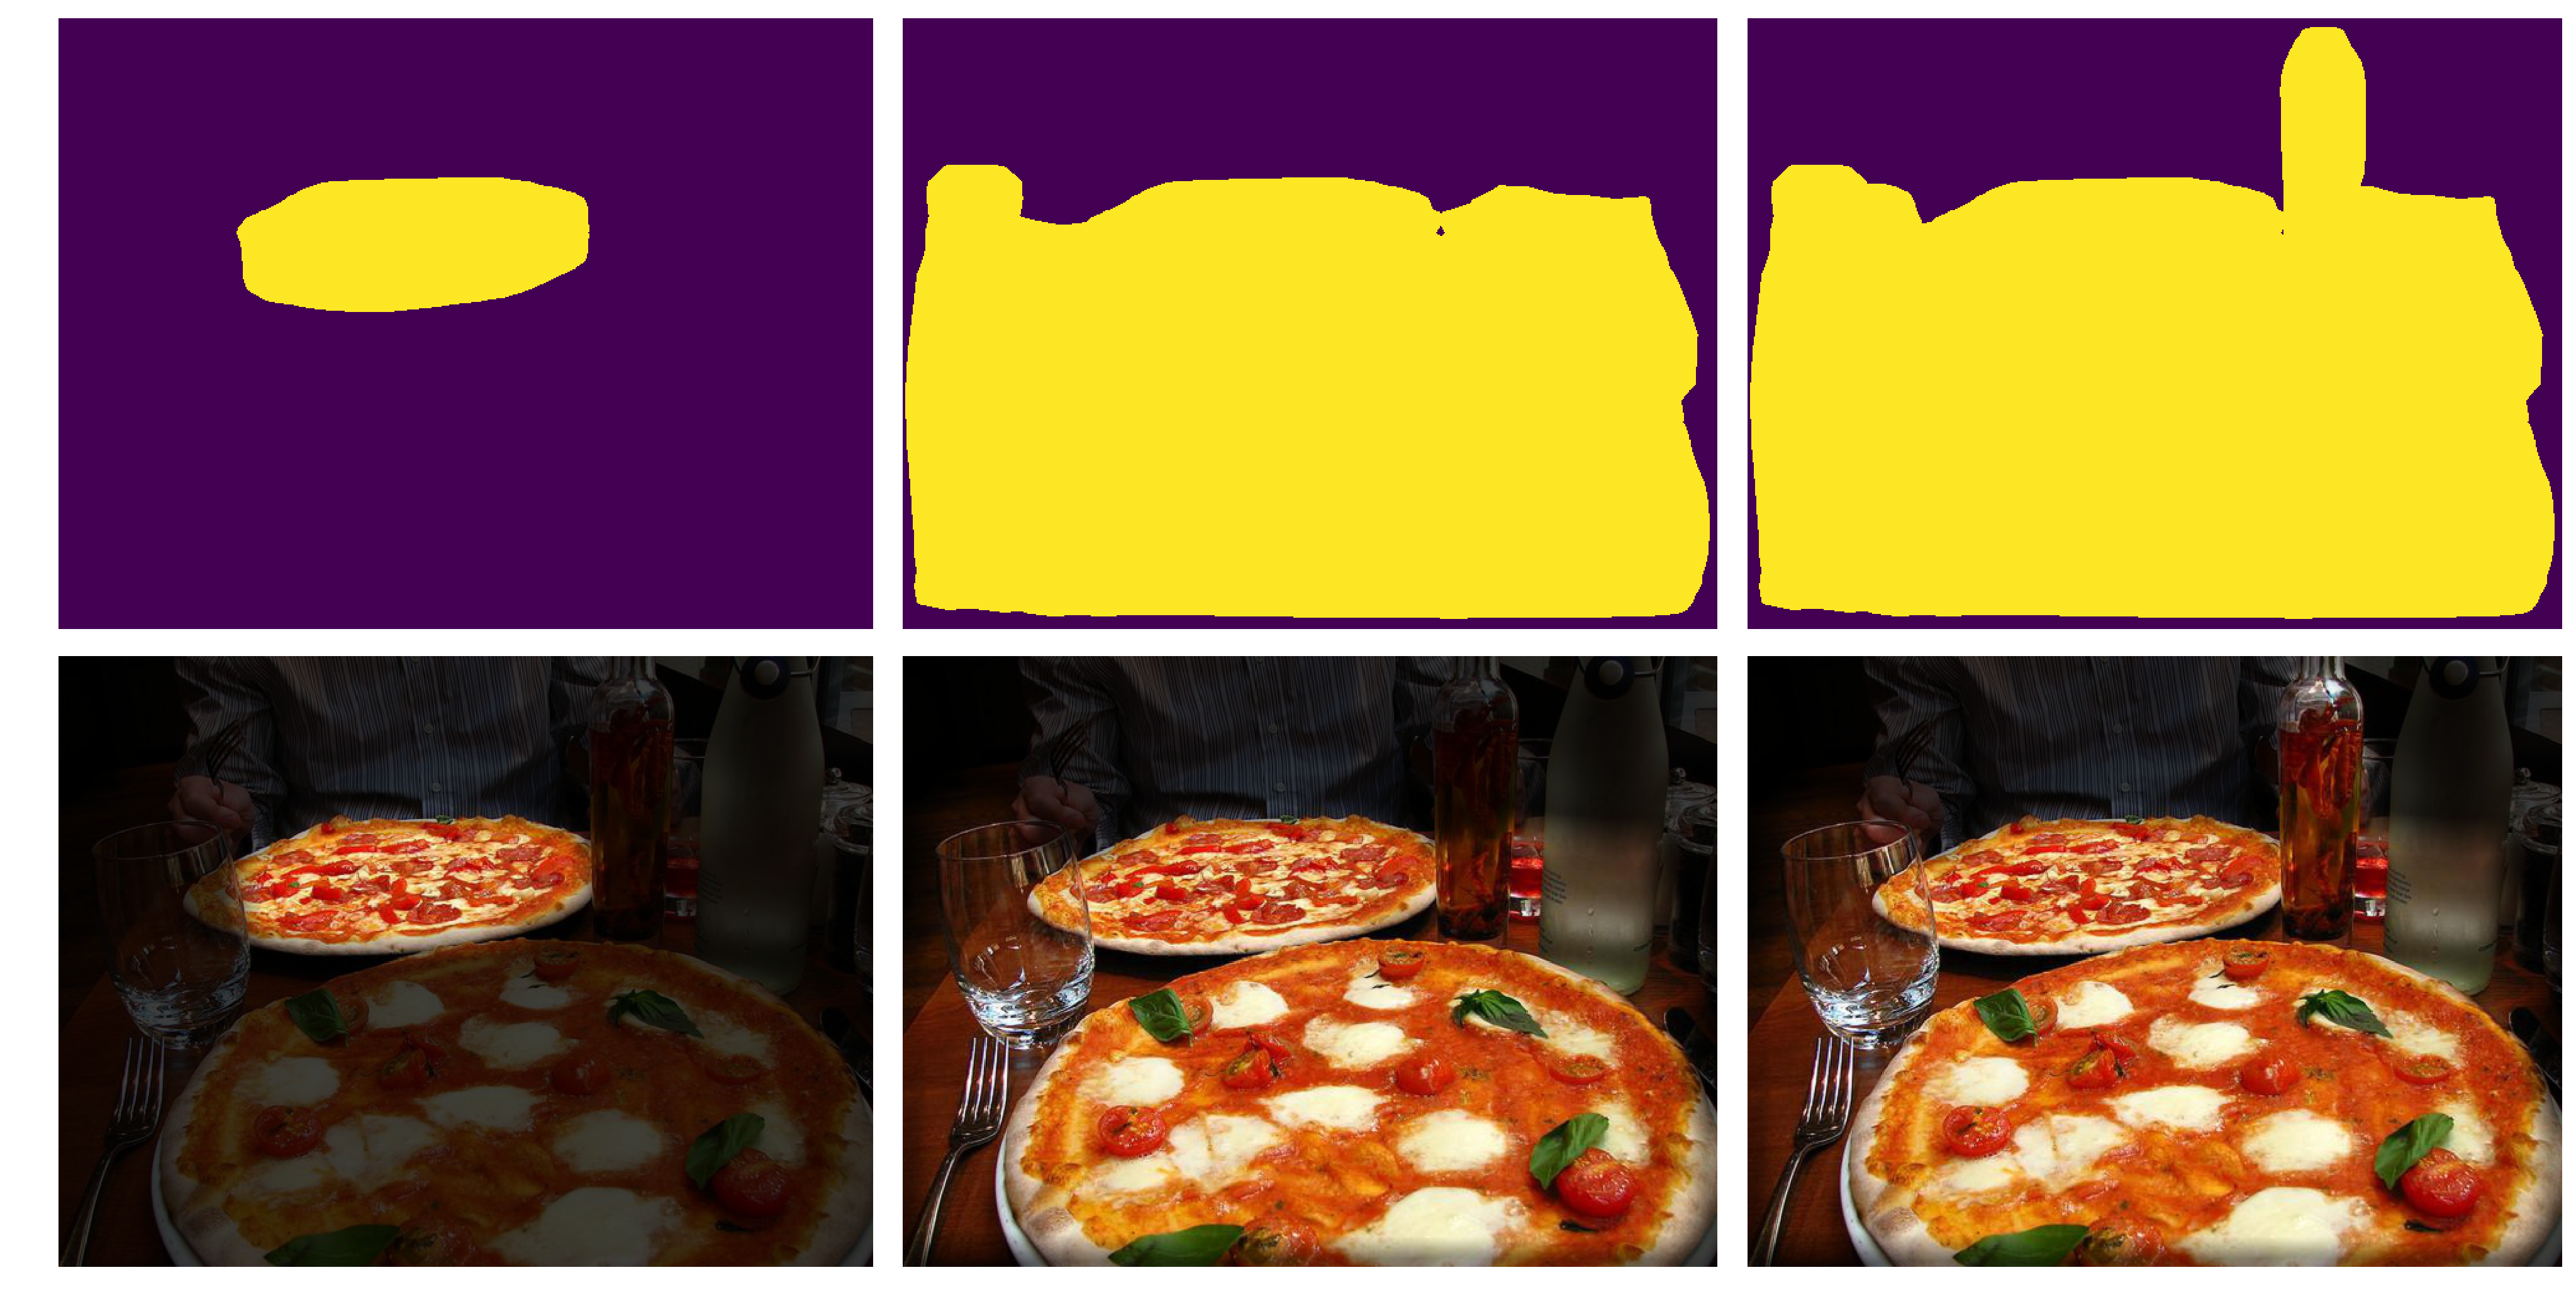

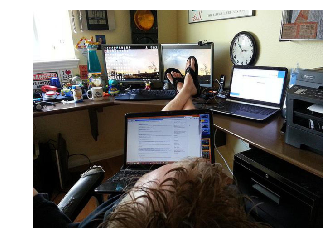

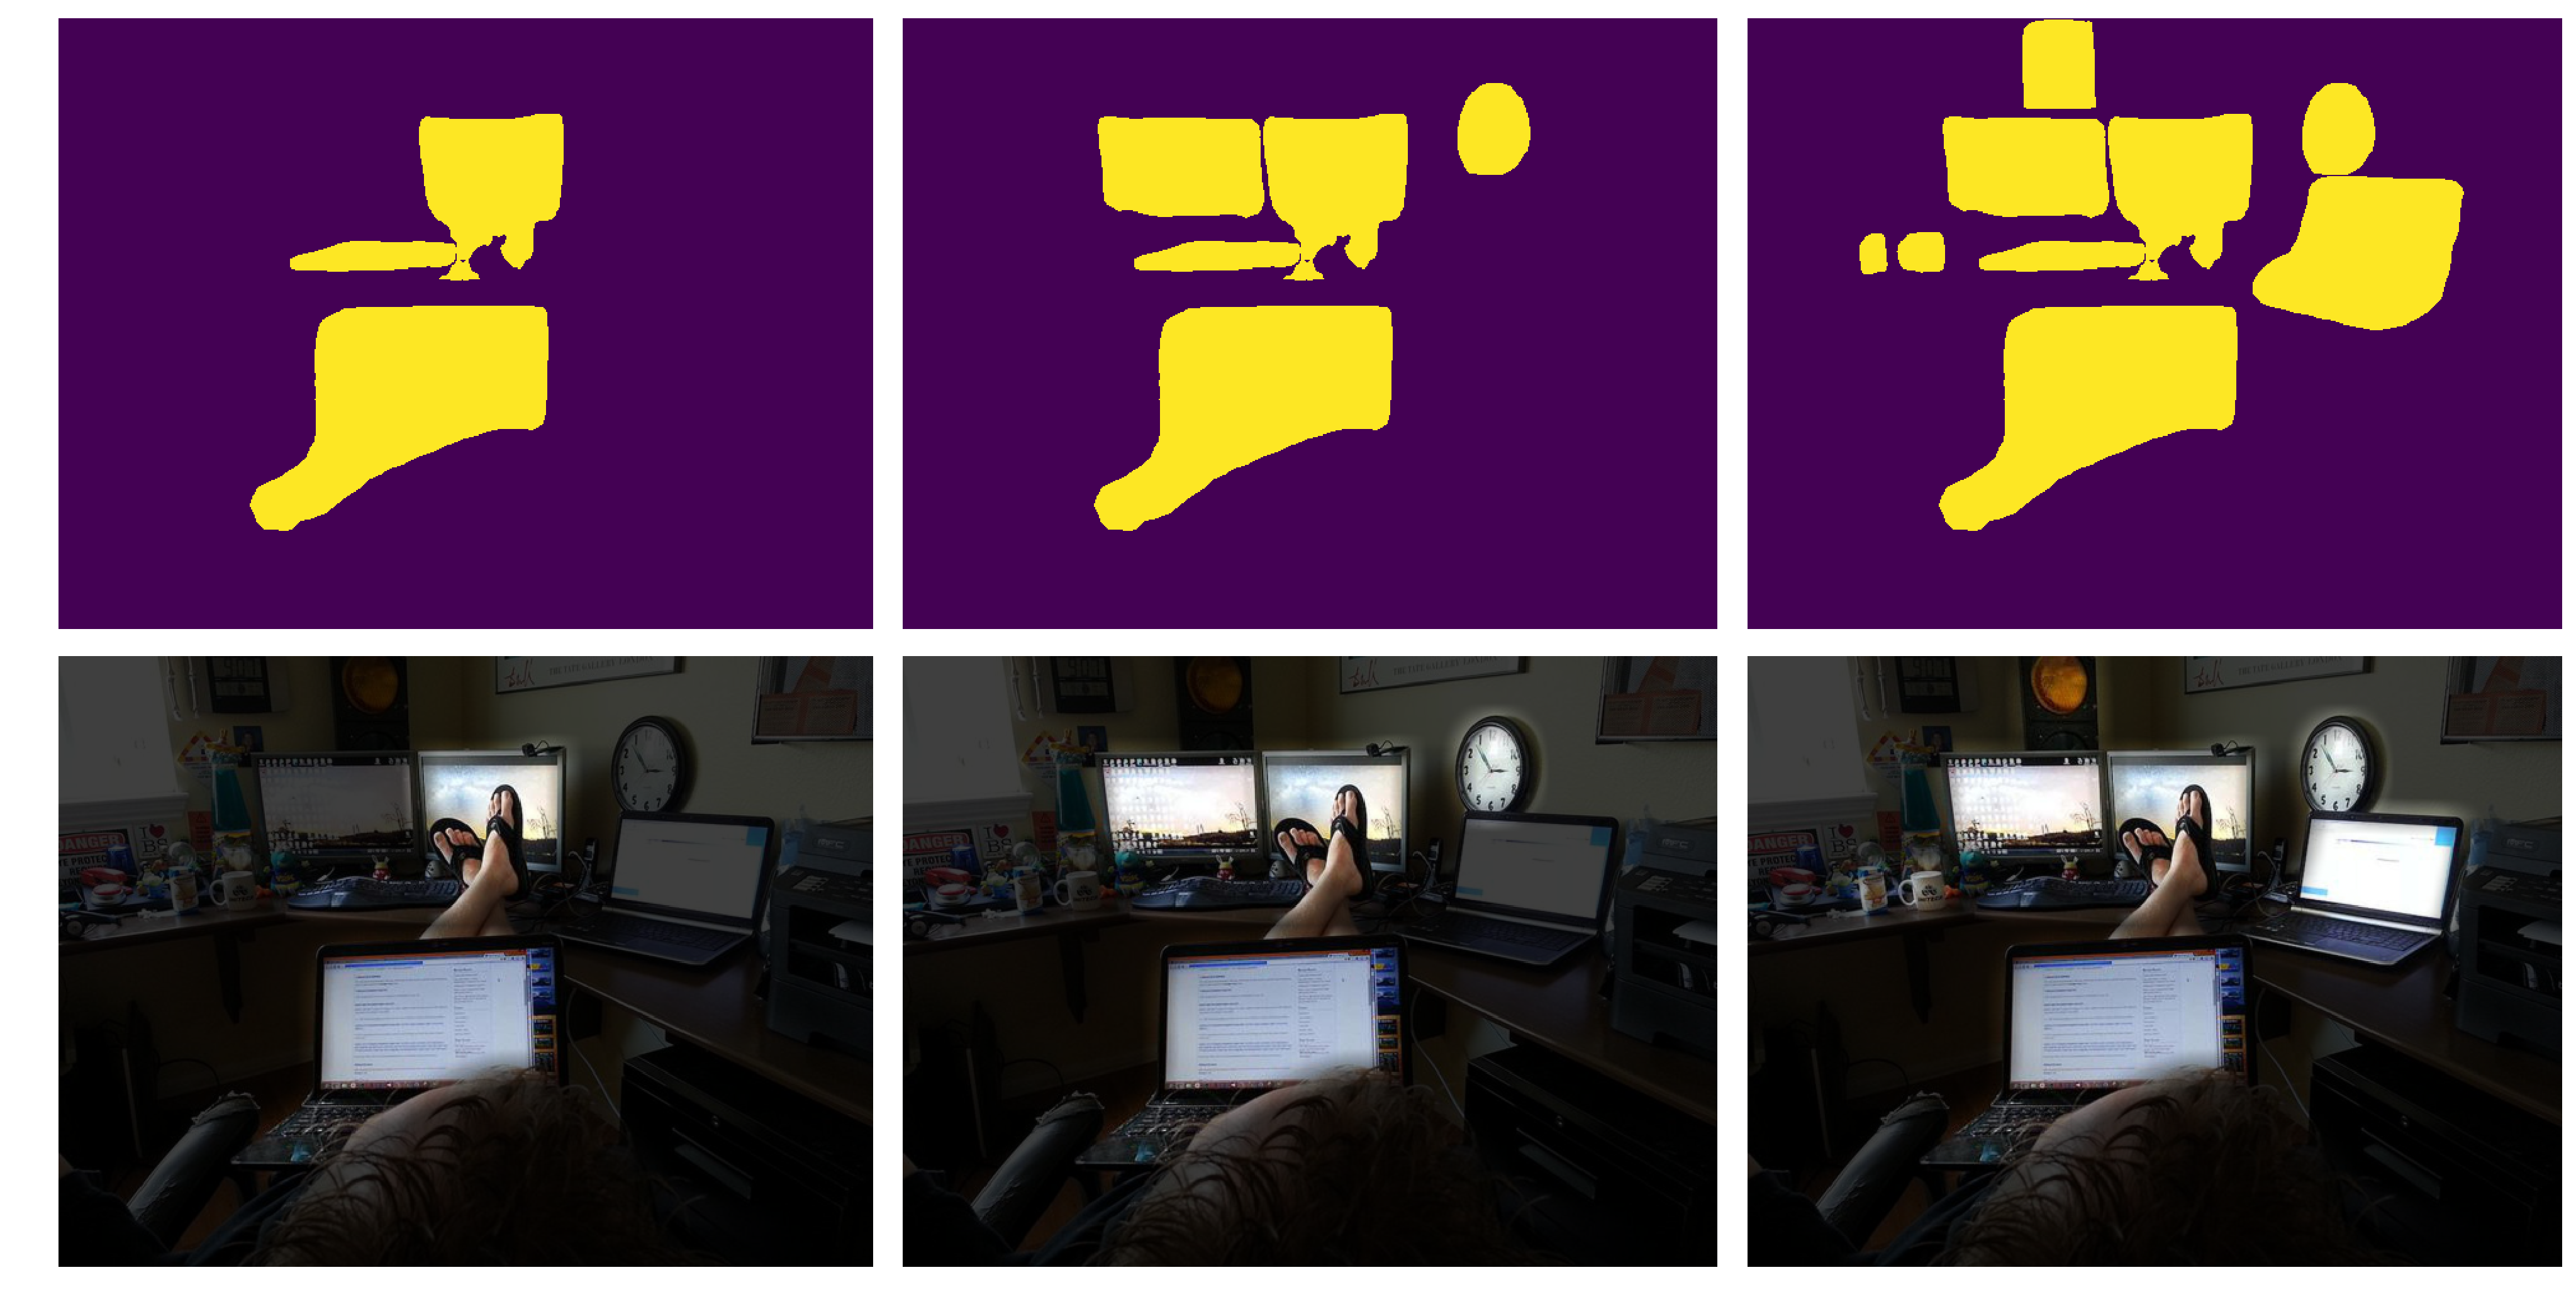

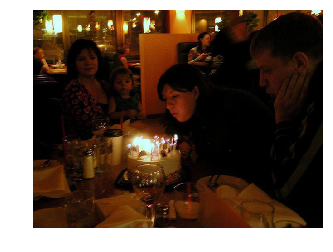

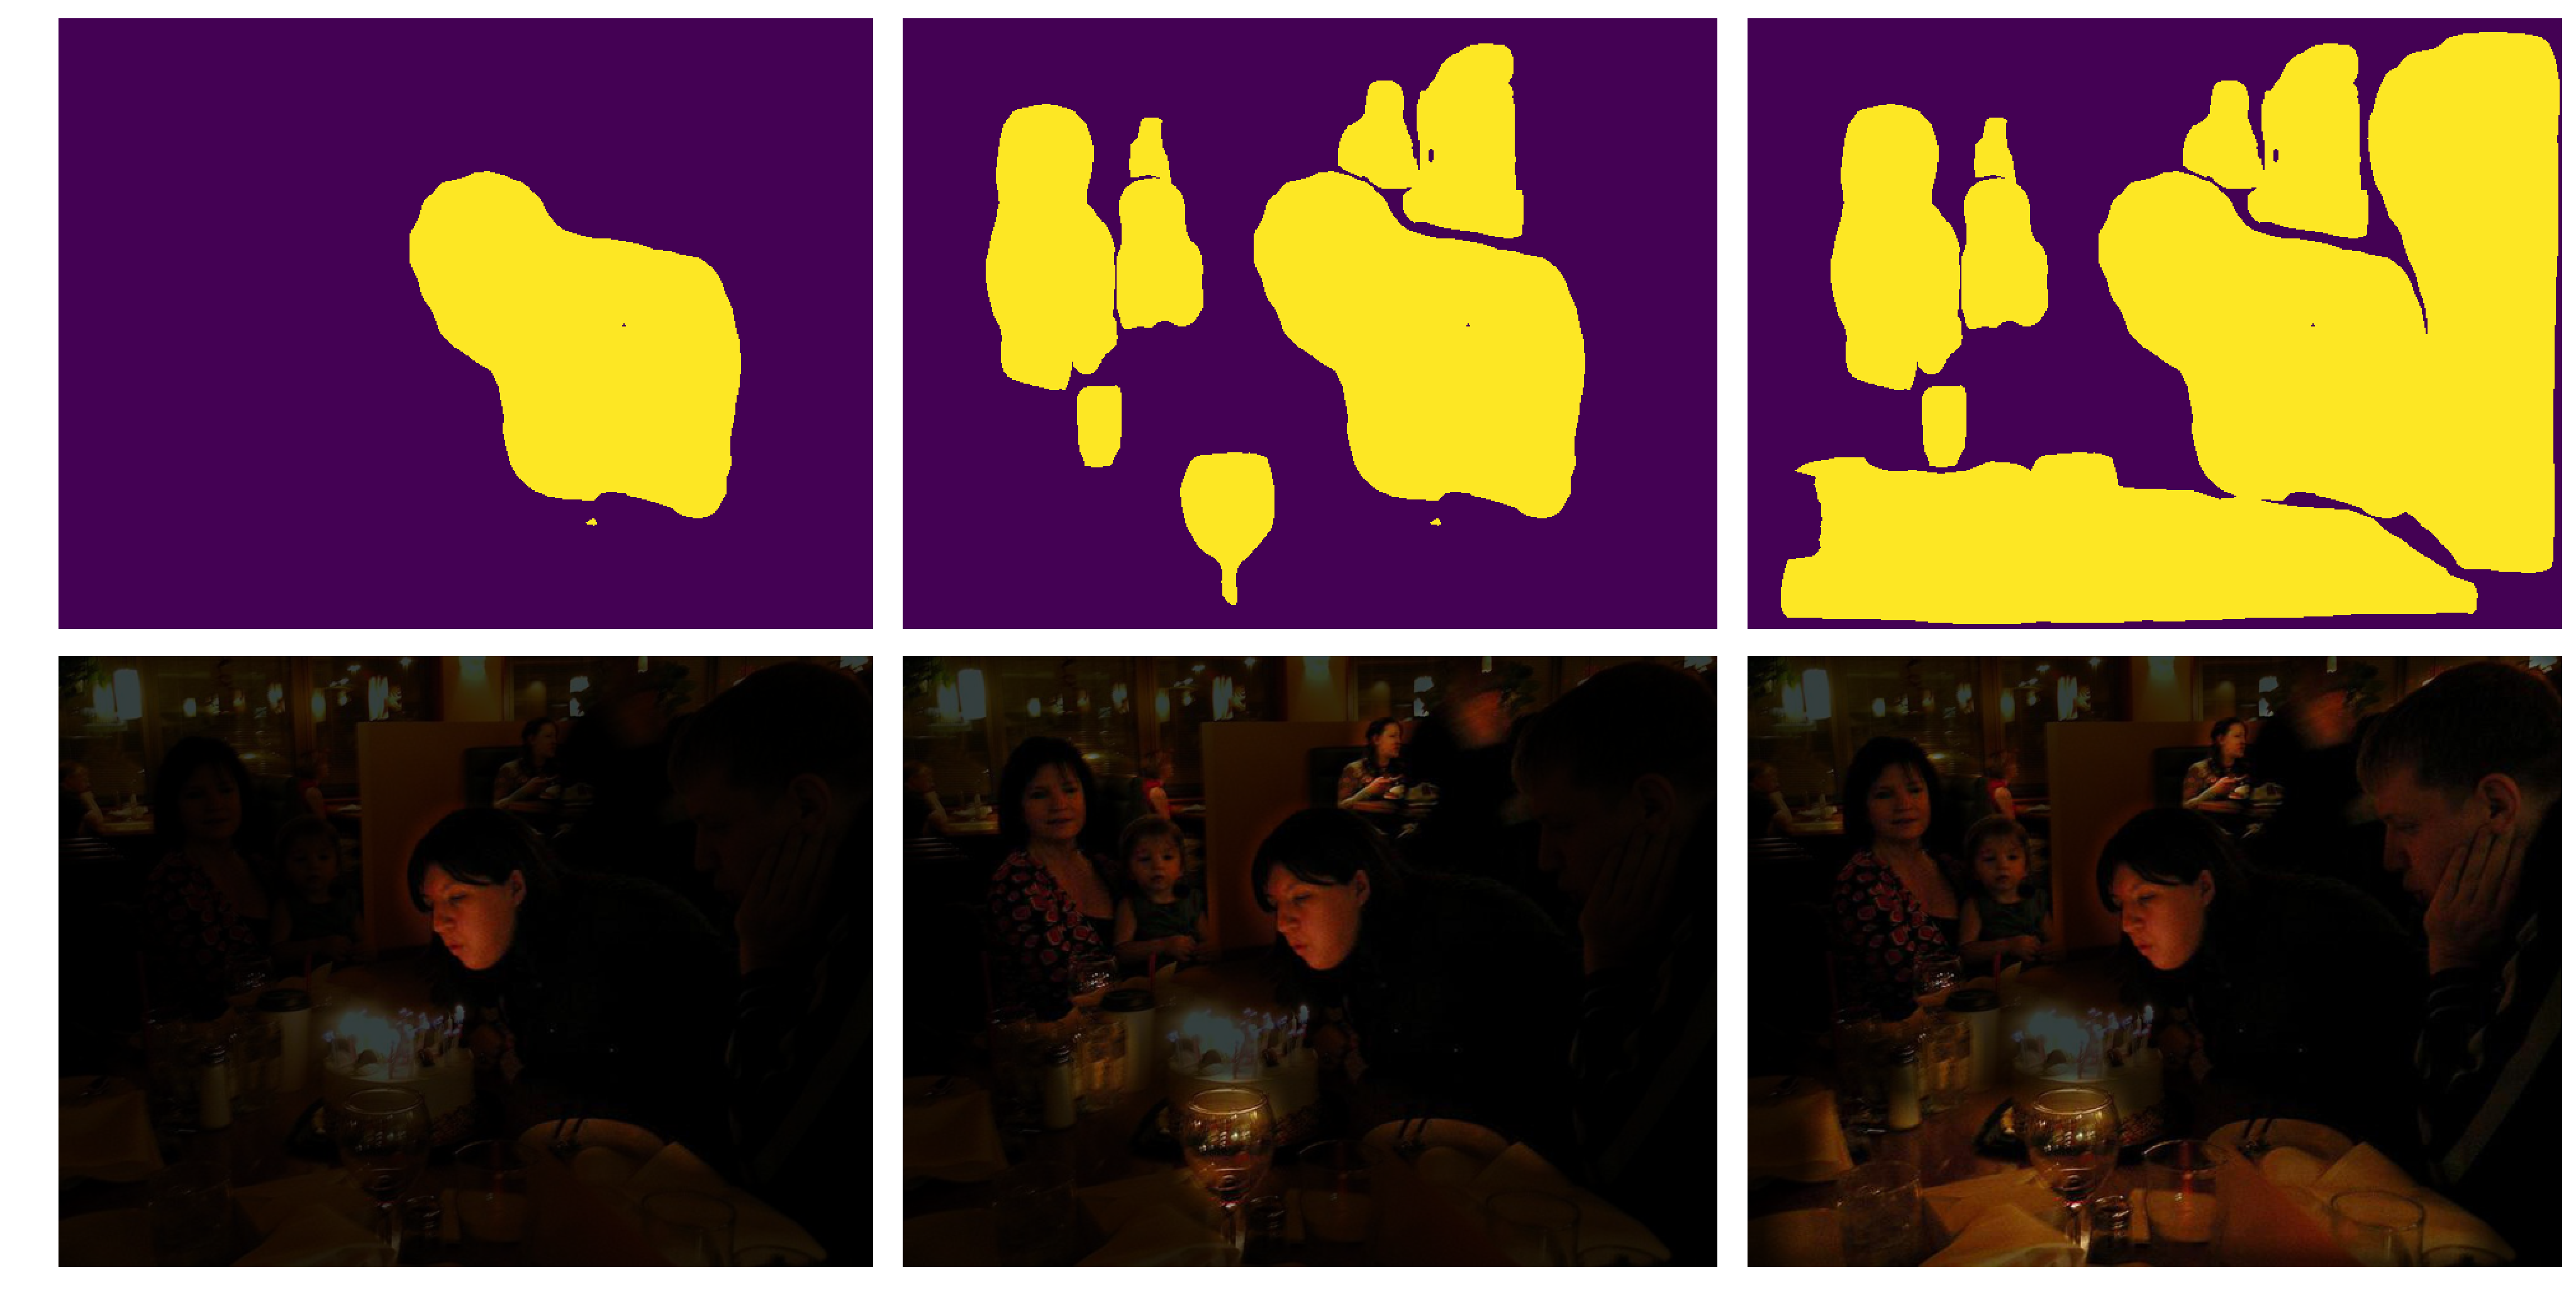

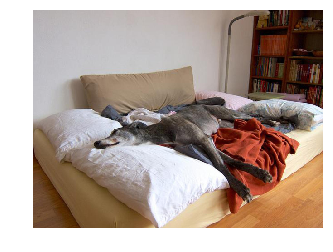

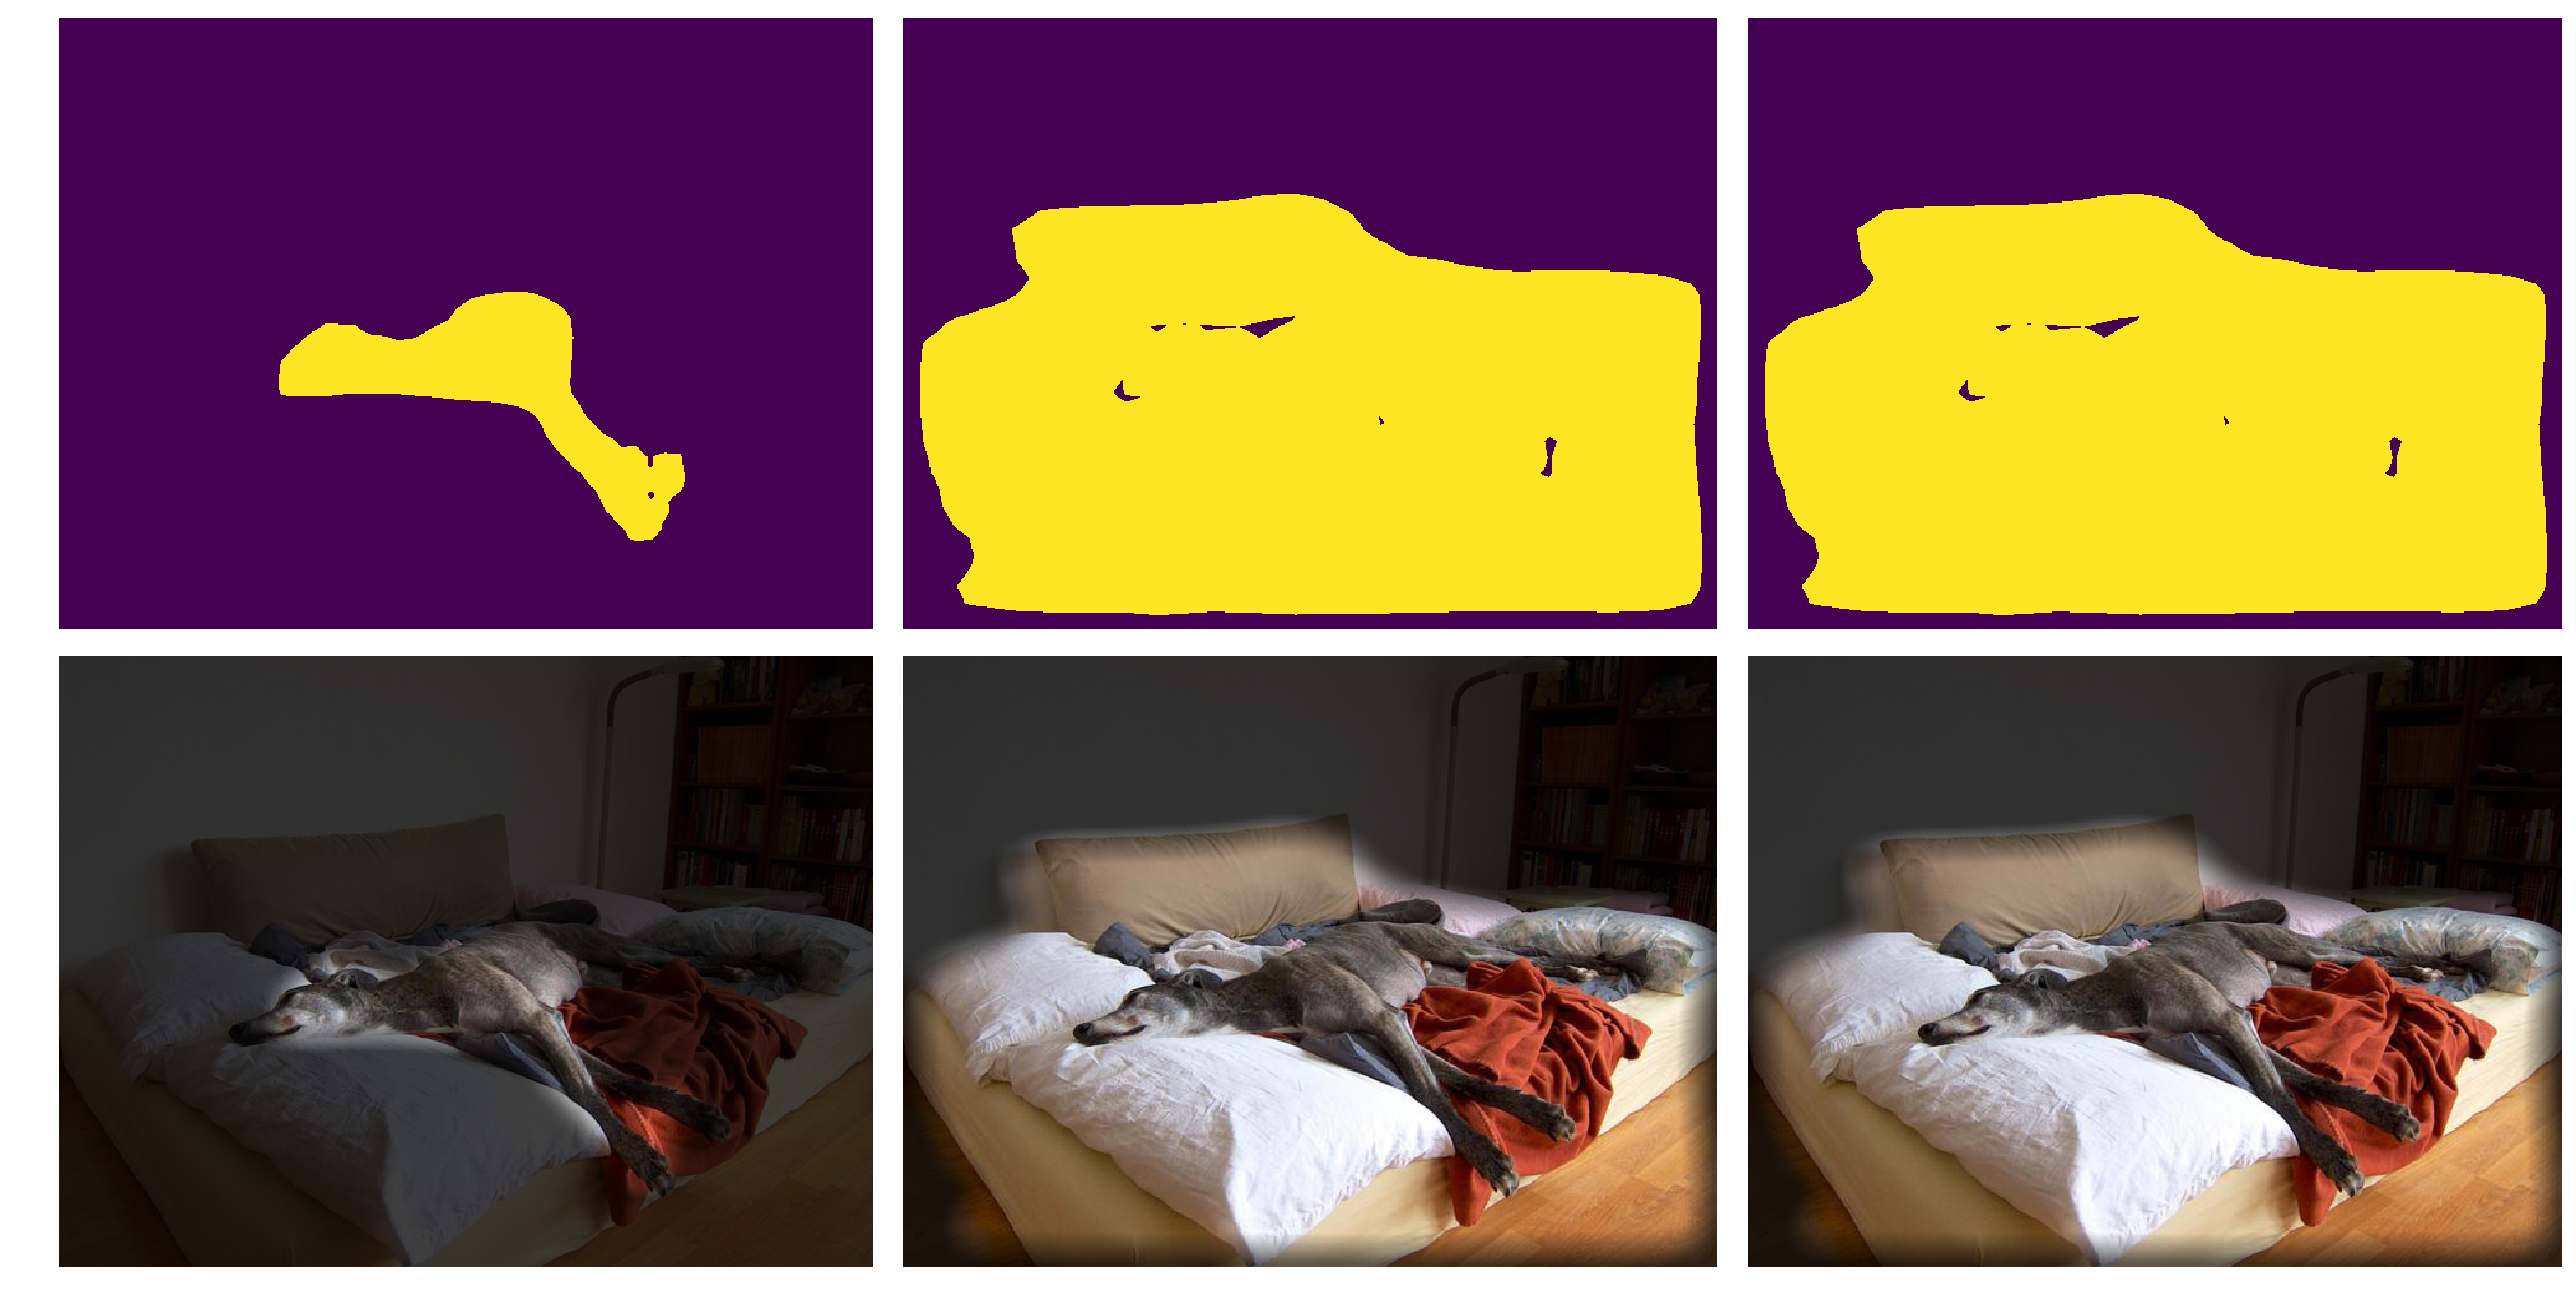

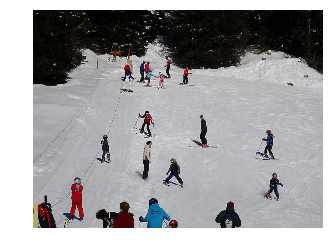

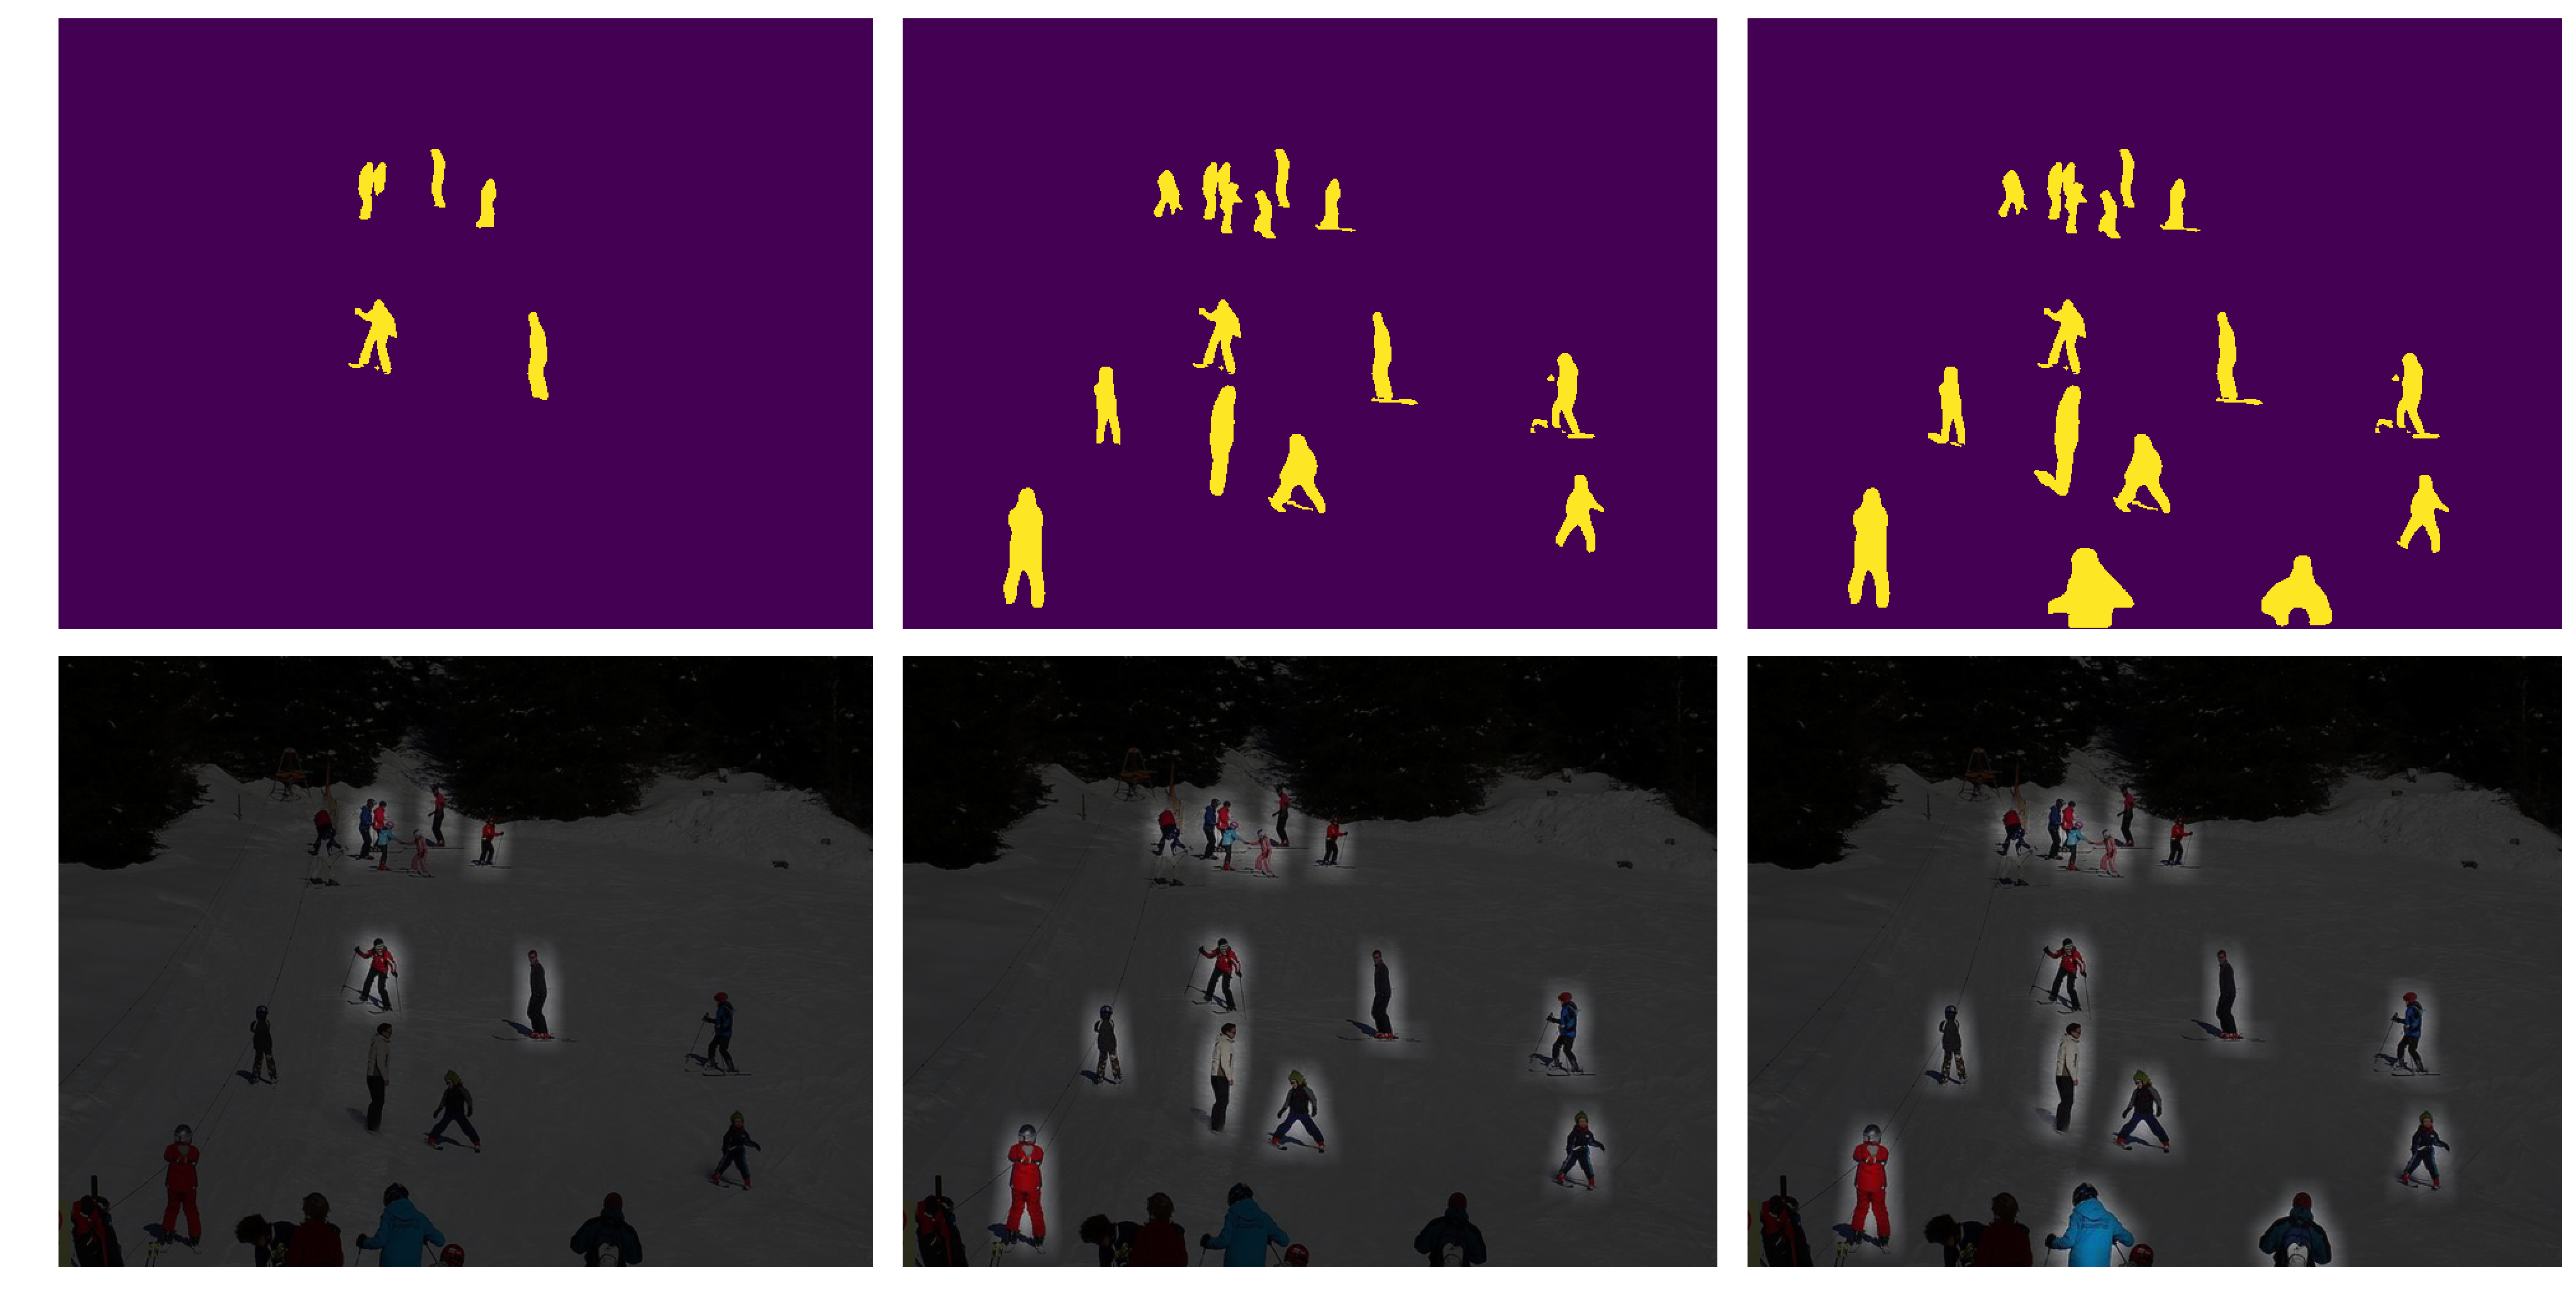

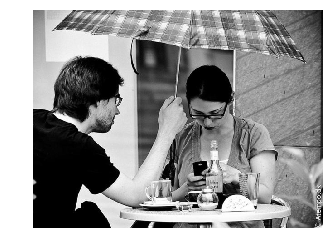

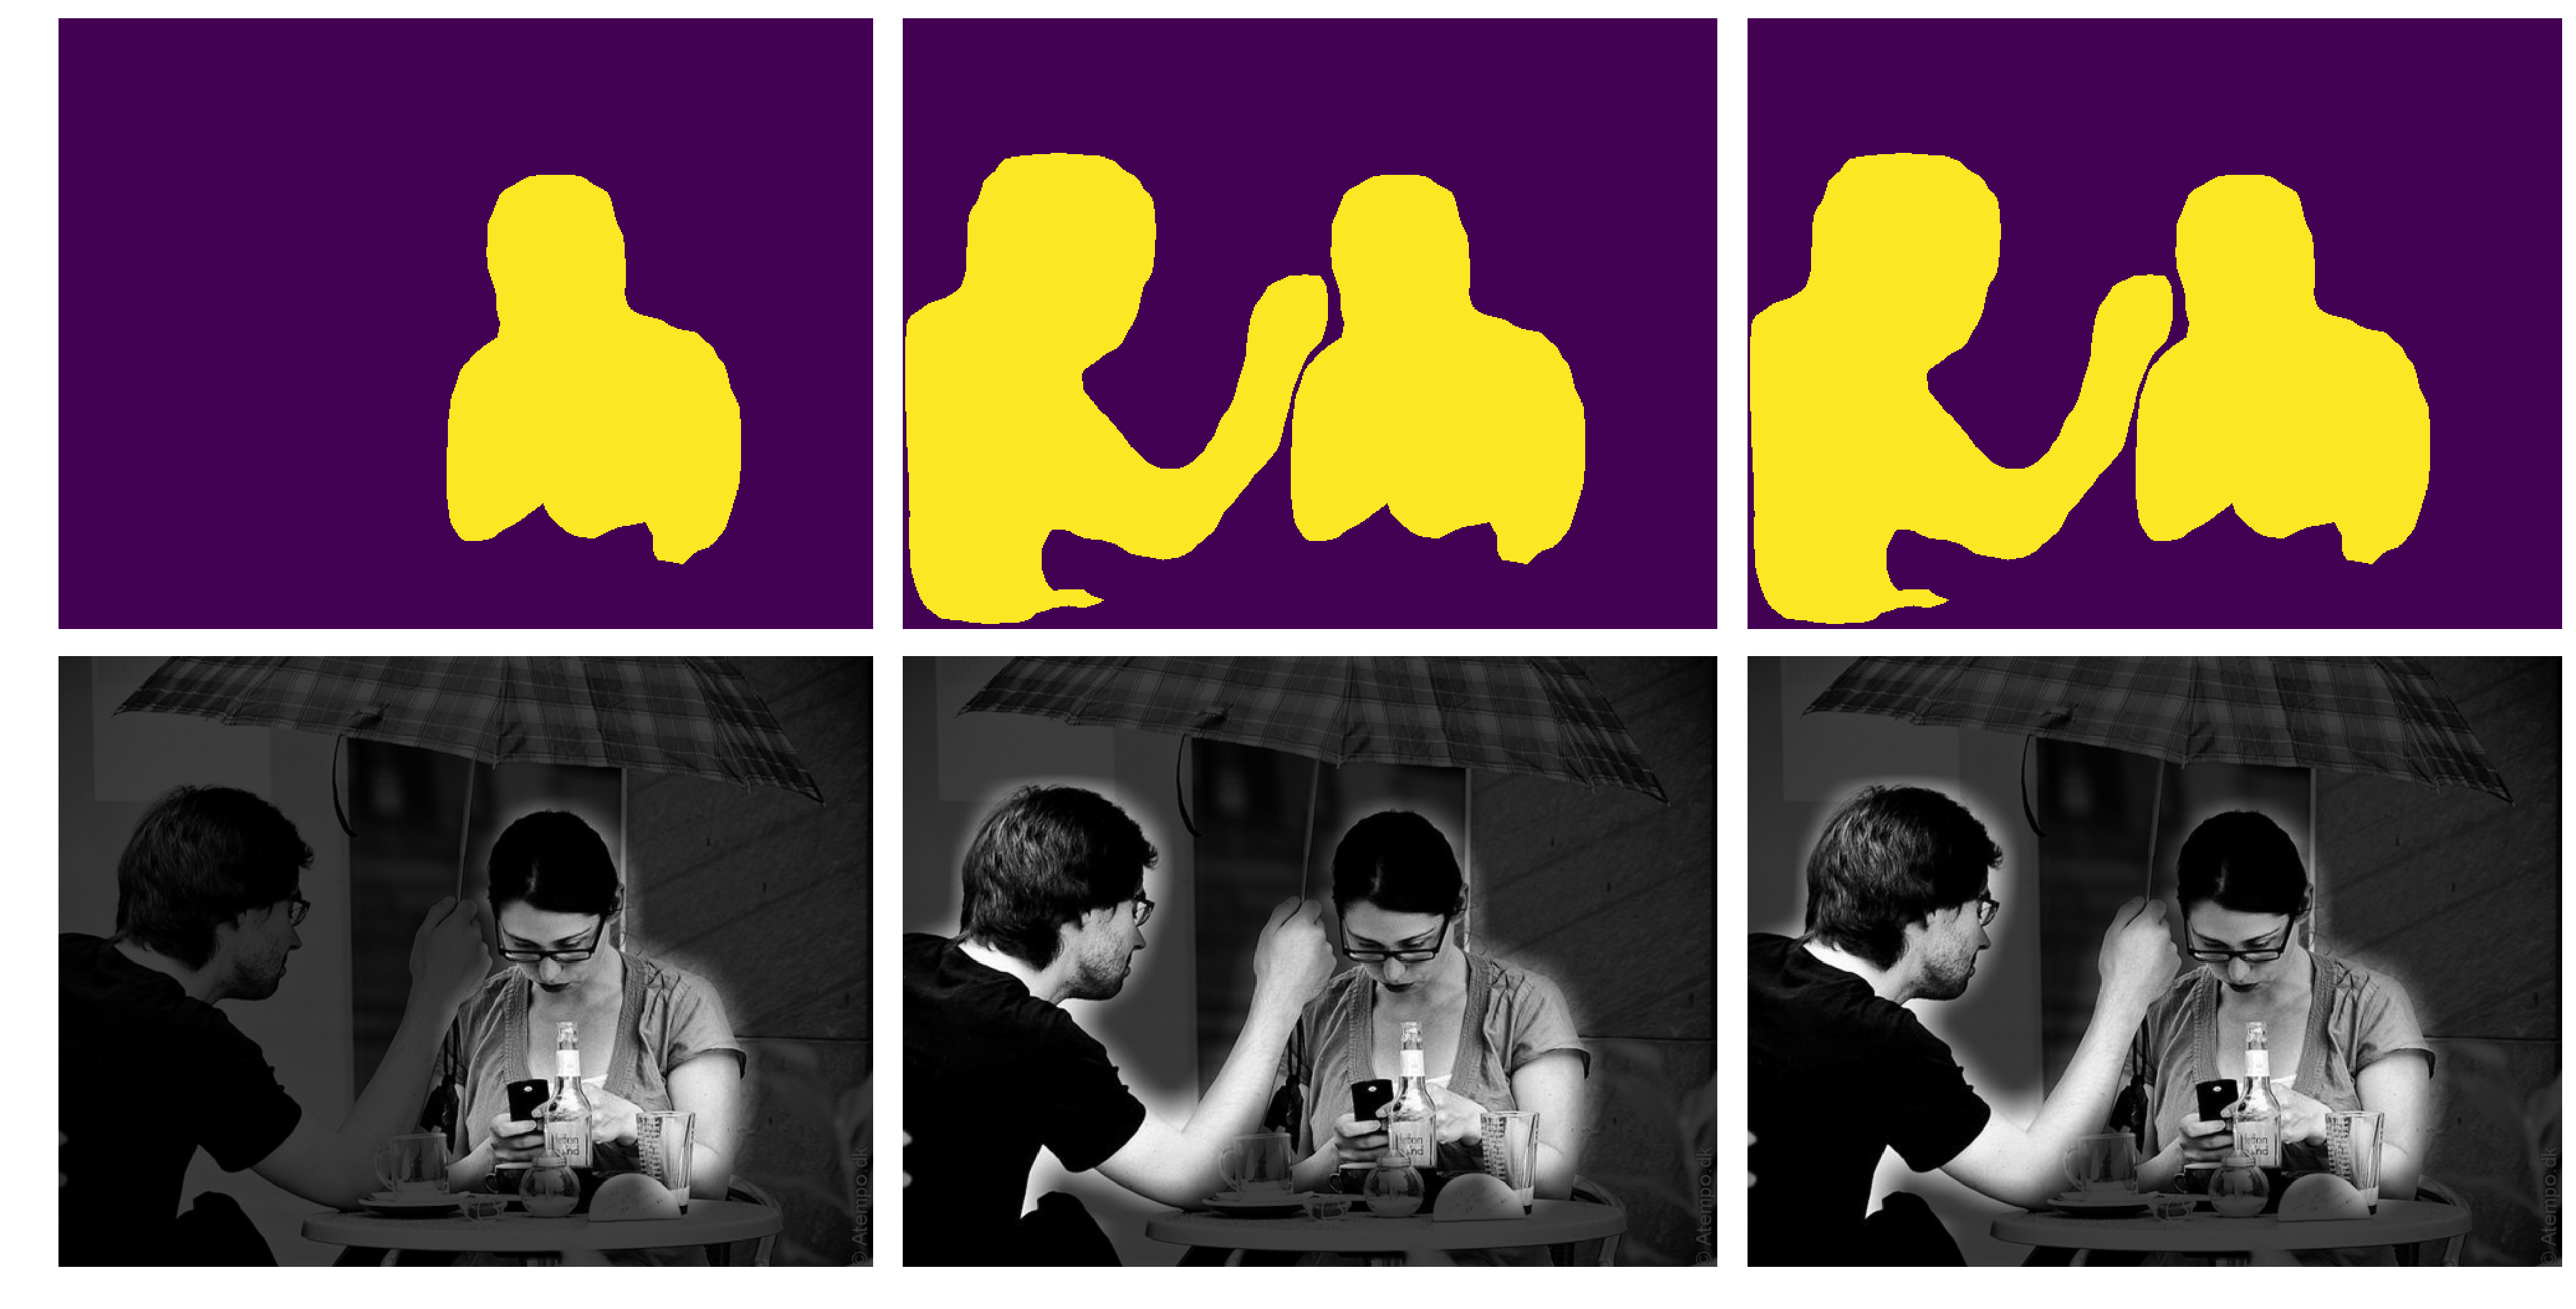

In [19]:

sigma=20
total_thr = []
for img_name in tqdm(images_list):
    if img_name not in selected_images: continue
    
    img_file = img_name+'.'+ori_filetype
    save_img_file = img_name+'.jpg'
    image = cv2.imread(os.path.join(jpg_path,img_file))
    if RESIZE:
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    save_dict['image'][img_name] = image

    imgblurred = cv2.GaussianBlur(image, (25,25), 0)
    imgblurred[:,:,:] = imgblurred[:,:,:]/4
    
    # Mask RCNN
    results = model.detect([image], verbose=0)        
    r = results[0]
    
    save_dict['r'][img_name] = r
    
    combined_mask = np.sum(r['masks'],axis=2)
    num_masks = r['masks'].shape[2]

    if (num_masks <= 5): continue
    instance_counts = np.zeros(num_masks)
    
    save_dict['combined_mask'][img_name] = combined_mask
       
    segmented_masks = r['masks']
    
    sal_imname = img_name + '.{}'.format(sal_filetype)
    sal_impaths = [os.path.join(saliency_path, sal_imname) for saliency_path in saliency_paths]
    prev_heatmaps = []
    if PLOT:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax = plt.gca()
        ax.axis('off')
        plt.show()
        fig,axes = plt.subplots(2,3,figsize=(20,10),dpi=200)
        axes = axes.flatten()
        for ax in axes:
            ax.axis('off')
    current_heatmap = np.zeros(image.shape[:2])
    threshold = 0.0
    for i, sal_impath in enumerate(sal_impaths):
        time_img_file = '{}_{}'.format(time_points[i], img_file)
        
        heatmap = cv2.imread(sal_impath, 0)
        if (RESIZE):
            heatmap = cv2.resize(heatmap, dim, interpolation = cv2.INTER_AREA)
        
        prev_heatmaps.append(heatmap.copy())
        current_heatmap+=heatmap
        if i==0:
            # pick 90 percentile
            threshold = np.percentile(current_heatmap.flatten(),90)

                
        for idx in range(num_masks):
            instance_counts[idx] = np.mean(current_heatmap[segmented_masks[:,:,idx]])
        indices = np.arange(len(instance_counts))[instance_counts > threshold]
        diff_list = list(set(np.arange(num_masks))-set(indices))   
        
        imp_mask = np.any(segmented_masks[:,:,indices], axis=2)
        
        new_img = image.copy()
        blur_mask = np.where(imp_mask.astype(int), 1, 1/4)
        blur_img = cv2.blur(blur_mask,(30,30))
        for k in range(3):
            new_img[:,:,k] = new_img[:,:,k]*blur_img
        
        
        if PLOT:
            axes[i].imshow(imp_mask)
            axes[i+3].imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    
    if PLOT:
        plt.tight_layout(pad=-1)
        plt.show()
    total_thr.append(threshold)